In [1]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 16.1 MB/s eta 0:00:00


In [2]:
pip install pymupdf pillow requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 36.4 MB/s eta 0:00:00


In [3]:
pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved: /content/cropped_fields/التاريخ.jpg
Saved: /content/cropped_fields/الفاتورة.jpg
Saved: /content/cropped_fields/السادة.jpg
Saved: /content/cropped_fields/الصنف.jpg
Saved: /content/cropped_fields/البيان.jpg
Saved: /content/cropped_fields/الكمية.jpg
Saved: /content/cropped_fields/القيمة.jpg
Saved: /content/cropped_fields/الإجمالي.jpg
Saved: /content/cropped_fields/الطبيب.jpg
Saved: /content/cropped_fields/المريض.jpg
Saved: /content/cropped_fields/ملاحظات.jpg
Saved: /content/cropped_fields/السعر.jpg


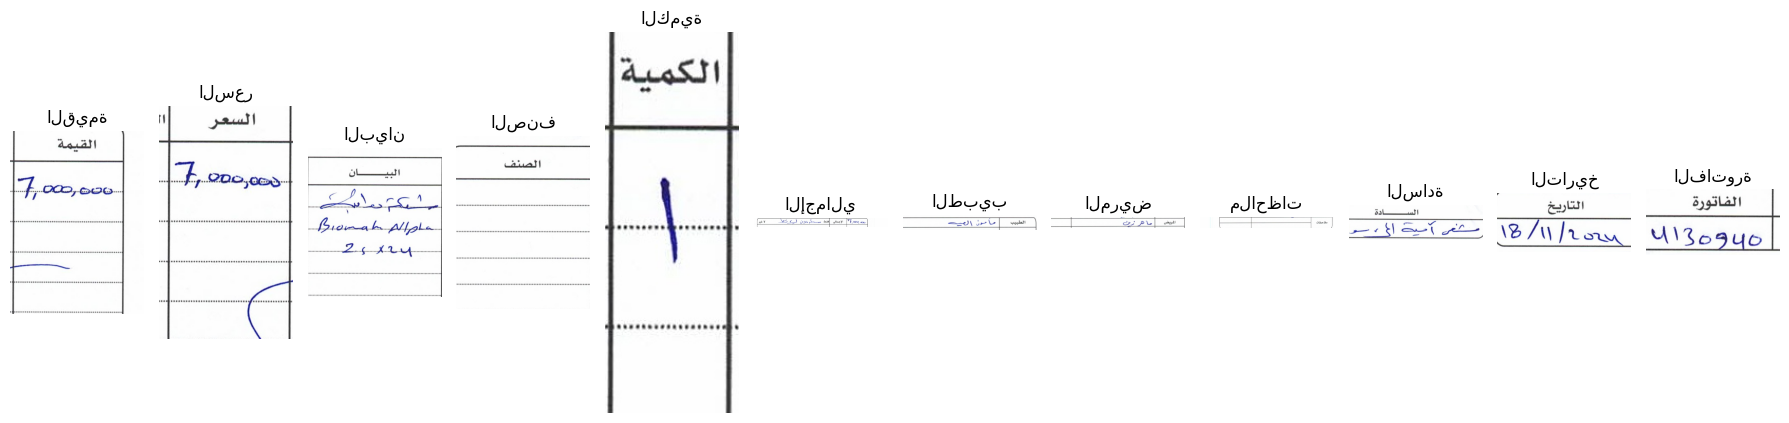

In [14]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import os
import requests
import json

# --------OCR --------
reader = easyocr.Reader(['ar'])


image_path = '/content/CCI_001117.jpg'
image = cv2.imread(image_path)
result = reader.readtext(image_path)


output_dir = "/content/cropped_fields"
os.makedirs(output_dir, exist_ok=True)


target_words_settings = {
    'القيمة': {'pad_x1': 140, 'pad_x2': 140, 'pad_y1': 20, 'pad_y2': 500},
    'السعر':  {'pad_x1': 110,  'pad_x2': 80, 'pad_y1': 20, 'pad_y2': 500},
    'البيان': {'pad_x1': 170,  'pad_x2': 170,  'pad_y1': 80, 'pad_y2': 500},
    'الصنف': {'pad_x1': 170,  'pad_x2': 170,  'pad_y1': 80, 'pad_y2': 500},
    'الكمية': {'pad_x1': 10,  'pad_x2': 10,  'pad_y1': 20, 'pad_y2': 300},
    'الإجمالي': {'pad_x1': 1300, 'pad_x2': 800, 'pad_y1': 30,  'pad_y2': 50},
    'الطبيب':   {'pad_x1': 1000, 'pad_x2': 100, 'pad_y1': 50,  'pad_y2': 40},
    'المريض':   {'pad_x1': 1300, 'pad_x2': 100, 'pad_y1': 30,  'pad_y2': 30},
    'ملاحظات': {'pad_x1': 2000, 'pad_x2': 100, 'pad_y1': 60,  'pad_y2': 60},
    'السادة':   {'pad_x1': 130,  'pad_x2': 330, 'pad_y1': 20,  'pad_y2': 120},
    'التاريخ':  {'pad_x1': 160,  'pad_x2': 150, 'pad_y1': 10,  'pad_y2': 120},
    'الفاتورة': {'pad_x1': 120,  'pad_x2': 100, 'pad_y1': 10,  'pad_y2': 120},
}


for (bbox, text, prob) in result:
    for word, pad in target_words_settings.items():
        if word in text:
            x1, y1 = map(int, bbox[0])  # top-left
            x2, y2 = map(int, bbox[2])  # bottom-right

            x1 = max(x1 - pad['pad_x1'], 0)
            y1 = max(y1 - pad['pad_y1'], 0)
            x2 = min(x2 + pad['pad_x2'], image.shape[1])
            y2 = min(y2 + pad['pad_y2'], image.shape[0])

            cropped = image[y1:y2, x1:x2]

            filename = f"{word}.jpg"
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, cropped)
            print(f"Saved: {save_path}")
            break


fig, axes = plt.subplots(1, len(target_words_settings), figsize=(18, 5))
for idx, word in enumerate(target_words_settings.keys()):
    path = os.path.join(output_dir, f"{word}.jpg")
    if os.path.exists(path):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(word)
        axes[idx].axis('off')
plt.tight_layout()
plt.show()
#***************************************************************************************************

In [15]:
import os
import requests
import json

# -------- ScanDocFlow --------
API_URL = "https://backend.scandocflow.com/v1/api/documents/extract"
ACCESS_TOKEN = "Me2HklGvNco2ERWxJcg2tBq3tx3EQbWTnFOpm3X7fWeSu6aAES7KXjb3b23DjA0h"
WEBHOOK_URL = ""

folder_path = "/content/cropped_fields"


finale_words = {}

for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)

    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    print(f"\n Sending file {filename} to ScanDocFlow...")

    with open(img_path, 'rb') as file_data:
        response = requests.post(
            f"{API_URL}?access_token={ACCESS_TOKEN}",
            files={'files': (filename, file_data, 'image/jpeg')},
            data={
                'webhookUrl': WEBHOOK_URL,
                'type': 'financial',
                'lang': 'ara'
            }
        )

    if response.status_code == 200:
        response_json = response.json()

        try:
            doc = response_json['documents'][0]['textAnnotation']
            words = doc['Pages'][0]['Words']

            #  descending
            sorted_words = sorted(words, key=lambda w: w['Outline'][0], reverse=True)

            print(f"\n Sorted (RTL Arabic) word list for {filename}:")
            text_line = ""
            for w in sorted_words:
                text_line += " " + w['Text']
                print(f"  → {w['Text']} at x={w['Outline'][0]}")

            finale_words[filename] = {"words": text_line.strip()}

        except Exception as e:
            print(f"Couldn't parse words for {filename}: {e}")
            finale_words[filename] = {"words": ""}

    else:
        print(f" Error: Status {response.status_code}")
        print(response.text)
        finale_words[filename] = {"words": ""}


final_json_path = "/content/finale_words.json"
with open(final_json_path, "w", encoding="utf-8") as f:
    json.dump(finale_words, f, ensure_ascii=False, indent=4)

print(f"\n Final results saved to {final_json_path}")



 Sending file السعر.jpg to ScanDocFlow...

 Sorted (RTL Arabic) word list for السعر.jpg:
  → السعر at x=0.36278
  → 7,000,000 at x=0.11041

 Sending file القيمة.jpg to ScanDocFlow...

 Sorted (RTL Arabic) word list for القيمة.jpg:
  → القيمة at x=0.34928
  → 7,000,000 at x=0.05742

 Sending file المريض.jpg to ScanDocFlow...

 Sorted (RTL Arabic) word list for المريض.jpg:
  → المريض at x=0.84299
  → ماهر at x=0.639
  → زين at x=0.53861

 Sending file البيان.jpg to ScanDocFlow...

 Sorted (RTL Arabic) word list for البيان.jpg:
  → w at x=0.68013
  → Alp at x=0.60101
  → 2 at x=0.58754
  → شبكة at x=0.57912
  → x at x=0.51684
  → البيان at x=0.30303
  → 26 at x=0.28114
  → بوابة at x=0.13131
  → Biomah at x=0.07912

 Sending file الطبيب.jpg to ScanDocFlow...

 Sorted (RTL Arabic) word list for الطبيب.jpg:
  → الطبيب at x=0.80303
  → مامون at x=0.54466
  → العيه at x=0.34131

 Sending file التاريخ.jpg to ScanDocFlow...

 Sorted (RTL Arabic) word list for التاريخ.jpg:
  → التاريخ at x=0.37

In [22]:
import json
import pandas as pd
import re
import os
from sentence_transformers import SentenceTransformer, util
import torch
from rapidfuzz import fuzz

# -------------------- downloude model --------------------
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# -------------------- downloude tables --------------------
df_products2 = pd.read_excel("products2.xlsx")
materials_raw = df_products2["Material Name"].dropna().astype(str).tolist()
latins_raw    = df_products2["Latin Name"].dropna().astype(str).tolist()

df_doctors = pd.read_excel("doctors.xlsx")
doctors_raw = df_doctors["اسم الطبيب"].dropna().astype(str).tolist()

df_clients = pd.read_excel("clients.xlsx")
clients_raw = df_clients["اسم العميل"].dropna().astype(str).tolist()

# -------------------- tools for arabic--------------------
AR_DIAC = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
TATWEEL = '\u0640'

def normalize_ar(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    s = s.replace(TATWEEL, '')
    s = AR_DIAC.sub('', s)
    s = re.sub('[إأآا]', 'ا', s)
    s = s.replace('ى', 'ي').replace('ئ', 'ي').replace('ؤ', 'و')
    s = s.replace('ة', 'ه')
    s = re.sub(r'[^\w\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def strip_titles(s: str) -> str:
    s = re.sub(r'\b(د|د\.|دكتور|الدكتور|دكتوره|الدكتوره|الطبيب|طبيب)\b', ' ', s)
    return re.sub(r'\s+', ' ', s).strip()

def remove_al(word: str) -> str:
    return re.sub(r'^(ال)', '', word)

def split_name(s: str):

    toks = s.split()
    if not toks:
        return "", ""
    first = toks[0]
    last = toks[-1] if len(toks) > 1 else ""
    return first, last

# cleaning doctors
doctors_norm = [normalize_ar(strip_titles(d)) for d in doctors_raw]
doctors_emb = model.encode(doctors_norm, convert_to_tensor=True)

# -------------------- OCR --------------------
with open("/content/finale_words.json", "r", encoding="utf-8") as f:
    finale_words = json.load(f)

# -------------------- Embeddings --------------------
materials_norm = [normalize_ar(m) for m in materials_raw]
latins_norm    = [normalize_ar(l) for l in latins_raw]

materials_emb = model.encode(materials_norm, convert_to_tensor=True)
latins_emb    = model.encode(latins_norm, convert_to_tensor=True)



clients_norm = [normalize_ar(c) for c in clients_raw]
clients_emb = model.encode(clients_norm, convert_to_tensor=True)

# -------------------- extact numbers--------------------
def extract_int_digits(text: str):
    if not isinstance(text, str):
        return None
    digits = re.sub(r'[^\d]', '', text)
    return int(digits) if digits else None

# -------------------- compare doctor -------------------
def best_doctor_match(query_text: str):

    q_clean = normalize_ar(strip_titles(query_text))
    if not q_clean:
        return None, 0.0

    q_first, q_last = split_name(q_clean)
    q_last_noal = remove_al(q_last)

    #first name
    cand_idx = [i for i, d in enumerate(doctors_norm) if q_first and q_first in d.split()]
    # last name
    if not cand_idx and q_last_noal:
        cand_idx = [i for i, d in enumerate(doctors_norm) if q_last_noal and remove_al(d.split()[-1] if d.split() else '') == q_last_noal]
    # first + last
    if not cand_idx:
        cand_idx = list(range(len(doctors_norm)))

    q_emb = model.encode(q_clean, convert_to_tensor=True)

    best_score = -1.0
    best_i = None

    for i in cand_idx:
        d = doctors_norm[i]
        toks = d.split()
        d_first = toks[0] if toks else ""
        d_last = toks[-1] if len(toks) > 1 else ""
        d_last_noal = remove_al(d_last)


        first_exact = 1.0 if q_first and d_first == q_first else 0.0
        last_exact  = 1.0 if q_last_noal and d_last_noal == q_last_noal else 0.0

        fuzz_score = fuzz.token_set_ratio(q_clean, d) / 100.0
        cos_score = util.cos_sim(q_emb, doctors_emb[i]).item()

        # best scour
        final_score = 1.2*first_exact + 1.0*last_exact + 0.5*fuzz_score + 0.3*cos_score

        if final_score > best_score:
            best_score = final_score
            best_i = i

    if best_i is None:
        return None, 0.0
    return doctors_raw[best_i], float(best_score)

# -------------------- compare client -------------------
def best_client_match(query_text: str):
    q_clean = normalize_ar(query_text)
    if not q_clean:
        return None, 0.0

    q_emb = model.encode(q_clean, convert_to_tensor=True)

    best_score = -1.0
    best_i = None

    for i, c in enumerate(clients_norm):
        fuzz_score = fuzz.token_set_ratio(q_clean, c) / 100.0
        cos_score = util.cos_sim(q_emb, clients_emb[i]).item()
        final_score = 0.6*fuzz_score + 0.4*cos_score

        if final_score > best_score:
            best_score = final_score
            best_i = i

    if best_i is None:
        return None, 0.0
    return clients_raw[best_i], float(best_score)





#----------------------------------- best_product_match --------------------
def best_product2_match(query_text: str):
    q_clean = normalize_ar(query_text)
    if not q_clean:
        return None, 0.0

    q_emb = model.encode(q_clean, convert_to_tensor=True)

    # --- search in Material Name ---
    best_score_m = -1.0
    best_i_m = None
    for i, m in enumerate(materials_norm):
        fuzz_score = fuzz.token_set_ratio(q_clean, m) / 100.0
        cos_score  = util.cos_sim(q_emb, materials_emb[i]).item()
        final_score = 0.6*fuzz_score + 0.4*cos_score
        if final_score > best_score_m:
            best_score_m = final_score
            best_i_m = i

    # --- search in Latin Name ---
    best_score_l = -1.0
    best_i_l = None
    for i, l in enumerate(latins_norm):
        fuzz_score = fuzz.token_set_ratio(q_clean, l) / 100.0
        cos_score  = util.cos_sim(q_emb, latins_emb[i]).item()
        final_score = 0.6*fuzz_score + 0.4*cos_score
        if final_score > best_score_l:
            best_score_l = final_score
            best_i_l = i

    # --- choose best between both ---
    if best_score_m >= best_score_l:
        return materials_raw[best_i_m], float(best_score_m)
    else:
        return latins_raw[best_i_l], float(best_score_l)
#----------------------------------------------------------------------------


final_results = {}
for fname, content in finale_words.items():
    ocr_text = content.get("words", "")
    key = os.path.splitext(fname)[0]

    if key == "الطبيب":
        match, score = best_doctor_match(ocr_text)
        final_results[key] = {"ocr": ocr_text, "match": match, "score": score}

    elif key == "البيان":
        match, score = best_product2_match(ocr_text)
        final_results[key] = {"ocr": ocr_text, "match": match, "score": score}

    else:
        final_results[key] = {"ocr": ocr_text, "match": None, "score": None}

import re
from datetime import datetime


def extract_int_digits(text: str):

    if not isinstance(text, str):
        return None
    digits = re.sub(r"[^\d]", "", text)
    return int(digits) if digits else None

def extract_date(text: str):

    if not isinstance(text, str):
        return None
    m = re.search(r'(\d{1,2})[\/\-](\d{1,2})[\/\-](\d{2,4})', text)
    if not m:
        return None
    d, mth, y = m.groups()
    if len(y) == 2:
        y = "20" + y
    try:
        return datetime(int(y), int(mth), int(d)).strftime("%d/%m/%Y")
    except:
        return None

# -------------------- validation qty / value / total /--------------------
qty_text   = finale_words.get("الكمية.jpg",   {}).get("words", "")
value_text = finale_words.get("القيمة.jpg",   {}).get("words", "")
total_text = finale_words.get("الإجمالي.jpg", {}).get("words", "")
price_text = finale_words.get("السعر.jpg",   {}).get("words", "")

qty   = extract_int_digits(qty_text)
value = extract_int_digits(value_text)
total = extract_int_digits(total_text)
price = extract_int_digits(price_text)

for k, txt in [("القيمة", value_text), ("الإجمالي", total_text), ("السعر", price_text)]:
    if k not in final_results:
        final_results[k] = {"ocr": txt, "match": None, "score": None}


candidates = [v for v in [value, total, price] if v is not None]
if candidates:
    bigger = max(candidates)

    final_results["القيمة"]["match"]   = bigger
    final_results["القيمة"]["score"]   = 1.0

    final_results["الإجمالي"]["match"] = bigger
    final_results["الإجمالي"]["score"] = 1.0

    final_results["السعر"]["match"]    = bigger
    final_results["السعر"]["score"]    = 1.0

# الكمية دائماً = 1
final_results["الكمية"] = {
    "ocr": qty_text,
    "match": 1,
    "score": 1.0
}



for key, content in final_results.items():
    ocr_text = content.get("ocr", "")

    if key == "الفاتورة":
        num = extract_int_digits(ocr_text)
        if num:
            final_results[key]["match"] = num

    elif key == "التاريخ":
        date_val = extract_date(ocr_text)
        if date_val:
            final_results[key]["match"] = date_val

    elif key == "السادة":
        match, score = best_client_match(ocr_text)
        final_results[key] = {"ocr": ocr_text, "match": match, "score": score}


    elif key == "المريض":
        if ocr_text.strip():
            final_results[key]["match"] = ocr_text.replace("المريض", "").strip()

    elif key == "الكمية":
        qty_val = 1
        final_results[key]["match"] = qty_val


for needed in ["الفاتورة","التاريخ","البيان","الصنف","السعر","القيمة","الإجمالي","الطبيب","المريض","الكمية","ملاحظات"]:
    if needed not in final_results:
        final_results[needed] = {"ocr": "", "match": None, "score": None}


out_path = "/content/final_db_ready.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(final_results, f, ensure_ascii=False, indent=4)

print(" Final JSON saved to:", out_path)


 Final JSON saved to: /content/final_db_ready.json
